In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


# Definir la función que representa el sistema de ecuaciones diferenciales
def pendulum(t, y, L, g):
    theta, omega = y  # theta es el ángulo, omega es la velocidad angular
    dtheta_dt = omega
    domega_dt = -(g / L) * np.sin(theta)
    return np.array([dtheta_dt, domega_dt])

In [43]:
from tqdm.notebook import tnrange


length_range = (0.1, 100)
gravity_range = (0.1, 100)
resolution = 300

lengths = np.linspace(*length_range, resolution)
gravities = np.linspace(*gravity_range, resolution)

# Intervalo de tiempo para la solución
t_span = (0, 10)
t_eval = np.linspace(*t_span, 1000)

total_iterations = len(lengths) * len(gravities) * len(t_eval)
results = np.empty((total_iterations, 4))

# Condiciones iniciales vectorizadas
y0 = np.array([np.pi / 2, 0])

current_row = 0
for length_index in tnrange(len(lengths), unit="longitud"):
    length = lengths[length_index]
    for gravity in gravities:
        sol = solve_ivp(
            pendulum, t_span, y0, t_eval=t_eval, args=(length, gravity), vectorized=True
        )

        length_array = np.full_like(sol.t, length)
        gravity_array = np.full_like(sol.t, gravity)

        result_chunk = np.vstack([sol.t, length_array, gravity_array, sol.y[0]]).T
        chunk_size = len(t_eval)
        results[current_row : current_row + chunk_size] = result_chunk
        current_row += chunk_size

  0%|          | 0/300 [00:00<?, ?longitud/s]

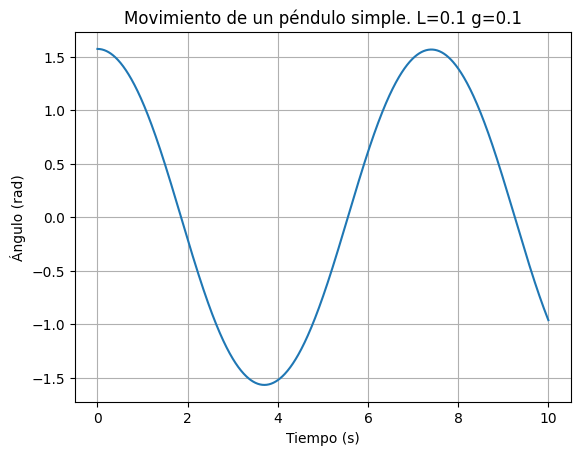

In [50]:
# Graficar los resultados para un péndulo simple
plt.plot(results[:1000, 0], results[:1000, 3])
plt.xlabel("Tiempo (s)")
plt.ylabel("Ángulo (rad)")
plt.title(f"Movimiento de un péndulo simple. L={length} g={gravity}")
plt.grid(True)
plt.show()

np.save("pendulum.npy", results)

In [4]:
data = np.load("pendulum.npy")
print(data.shape)

(90000000, 4)


In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X = data[:, :3]
y = data[:, 3]
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

In [9]:
# Creamos la FFNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

model = Sequential()
model.add(Input(shape=(3,)))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mse", metrics=["root_mean_squared_error"])

In [8]:
history = model.fit(
    X_train, y_train, epochs=10000, validation_data=(X_test, y_test), verbose=True
)

Epoch 1/10000
1038994/2250000 ━━━━━━━━━━━━━━━━━━━━ 22:37 1ms/step - loss: 0.0042 - root_mean_squared_error: 0.0632

KeyboardInterrupt: 